## Bayesian parameter estimation using MCMC

Authors: Audrey Olivier and Dimitris Giovanis <br>
Last modified on 12/14/2018 by Audrey Olivier

In Bayesian parameter estimation, one is looking to estimate the posterior pdf of the parameter vector characterizing the model, based on available data. The posterior pdf is given by Bayes' theorem:

$$ p(\theta \vert data) = \frac{p(data \vert \theta) p(\theta)}{p(data)} $$

The posterior pdf of nonlinear non-Gaussian models is often intractable, approximations must be used. In particular, Markov Chain Monte Carlo methods are a very popular way to sample from the posterior pdf. This notebook illustrates how to perfrom Bayesian parameter estimation via MCMC in UQpy, using the BayesParameterEstimation class. At the end of this notebook, we also show how to quickly check your results using some simple Diagnostics tools implemented in UQpy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

Generate data from a probability model, here a Gaussian pdf, then learn its parameters, mean and covariance, from this data.

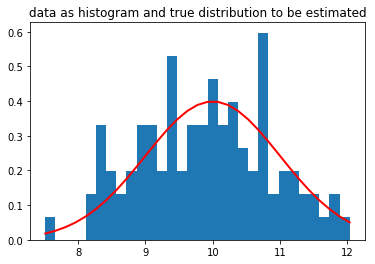

In [2]:
np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data_1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In a Bayesian setting, the definition of a prior pdf is a key point. The prior for the parameters must be defined in the model. Note that if no prior is given, an inproper, uninformative, prior is chosen, $p(\theta)=1$ for all $\theta$.

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', n_params=2,
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

In [4]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data_1, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal = 'Normal', pdf_proposal_scale=[1, 1], model=candidate_model, 
                                           algorithm = 'MH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

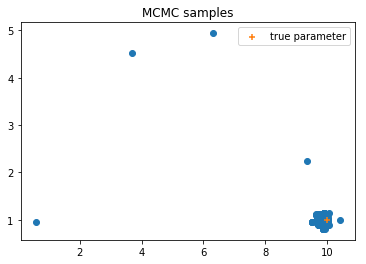

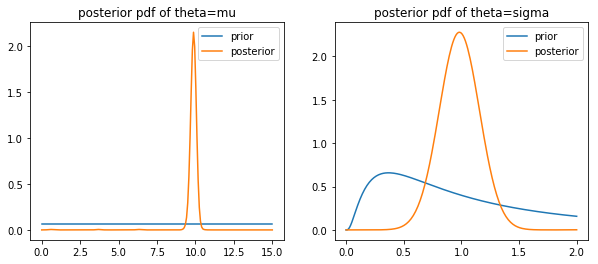

In [5]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4))

domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, Distribution('uniform').pdf(domain, [0,15]), label='prior')
ax[0].plot(domain, np.exp(log_dens), label='posterior')
ax[0].set_title('posterior pdf of theta=mu')
ax[0].legend()

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, Distribution('lognormal').pdf(domain, [1,0,1]), label='prior')
ax[1].plot(domain, np.exp(log_dens), label='posterior')
ax[1].set_title('posterior pdf of theta=sigma')
ax[1].legend()

plt.show()

## Regression model - $y=X \theta + \epsilon$

In [6]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  0.90606841   0.90429092   0.83008005   0.36300647   1.11368383
   4.43376473   4.1304201    6.45240013   5.17437843  10.34835049
   8.45954473  14.16588154  14.45803088  17.76679436  18.82542351
  22.8543563   24.48079262  25.87590759  30.90033666  34.01170511
  37.06448486  42.38342493  45.53502261  46.63165654  53.28029689
  56.13632465  61.16986043  65.32433783  69.76729808  75.51511587
  81.29970286  85.52640354  91.62769541  96.51705769 102.61511957
 108.42392834 114.63468385 121.5378179  130.39093193 133.54878077
 140.6587263  149.14957314 154.78140167 163.28124304 171.26234586
 178.02286459 186.2350996  194.03447343 201.72718255 209.46881579]


In [7]:
candidate_model = Model(n_params=2, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic',
                        error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method = 'MCMC', nsamples=500,
                                           algorithm = 'MH', jump=10, nburn=0, pdf_proposal = 'Normal',
                                           pdf_proposal_scale = [0.1, 0.05], seed = [0.5, 2.5])

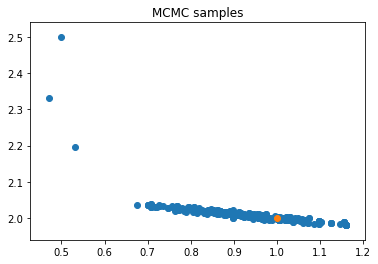

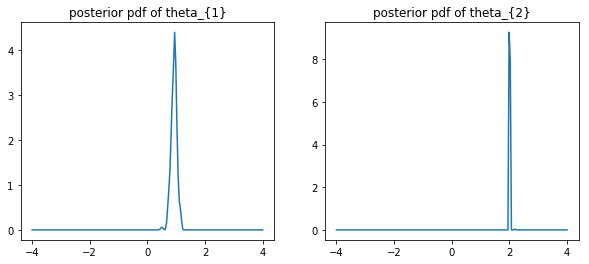

In [9]:
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4))

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()

Diagnostics for MCMC 

Acceptance ratio of the chain = 0.0638127625525105. 

Univariate Effective Sample Size in each dimension:
Parameter # 1: ESS = 1894.185543700042, minimum ESS recommended = 6146.334113110603
Parameter # 2: ESS = 3128.1388591624413, minimum ESS recommended = 6146.334113110603

Multivariate Effective Sample Size:
Multivariate ESS = 3072.63690789005, minimum ESS recommended = 7529.096402175249


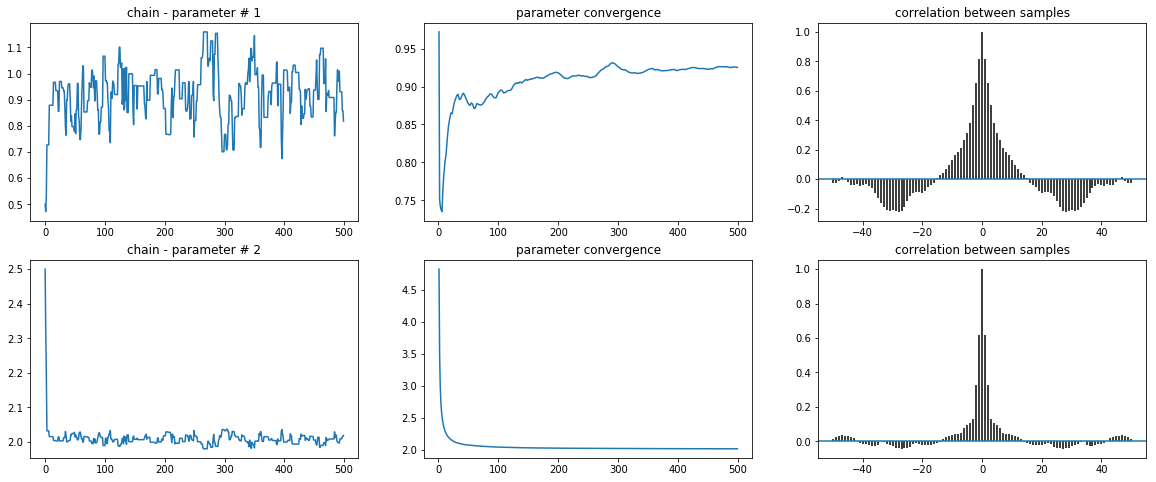

(<Figure size 1440x576 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1144bacf8>,
       dtype=object))

In [10]:
from UQpy.Utilities import diagnostics
diagnostics(sampling_method='MCMC', sampling_outputs = bayes_estimator)

Looking at the chains above, it appears that a better proposal should be chosen for that problem in order to get better mixing properties of the chain. This can also be seen through the small value of the acceptance ratio (it is often recommended to choose the proposal in order to obtain an acceptance ratio between 20-40%). Finally, it seems that estimation of the first parameter would require more fine tuning, as convergence is not yet achieved, and the ESS is small compared to the recommended minESS. One should thus probably run the chains for a longer time to obtain satisfactory estimates of the parameters and their posterior pdfs.